In [147]:
import sys
sys.path.append('..')
import sklearn
import wandb
from tsai.basics import *
from swdf.losses import *
from swdf.utils import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from itertools import chain



In [148]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config_train = config_solfsmy.train
config_data = config_solfsmy.data 

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_train, 
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.learner1, config.learner2 = AttrDict(), AttrDict()
    config.learner1.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
    config.learner2.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

config.learner1.init_weights = config.init_weights
config.learner2.init_weights = config.init_weights
config.pop('init_weights', None)

False

In [149]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [150]:
config

```json
{ 'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'data': { 'add_time_channels': False,
            'data_columns': ['F10', 'S10', 'M10', 'Y10'],
            'data_nb': './solfsmy_data.ipynb',
            'data_path': '../data/SOLFSMY.TXT',
            'data_time_columns': ['Year', 'DDD'],
            'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
            'df_save_path': './preprocessed_data/dataframes/solfsmy.pkl',
            'force_download': False,
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_solfsmy.pkl'},
  'deltaHL': 4.0,
  'horizon': 6,
  'is_optuna_study': False,
  'learner1': { 'arch': { 'attn_dropout': 0.4,
                          'd_model': 1024,
                          'dropout': 0.2,
                          'n_heads': 32},
                'init_weights': False},
  'learner2': { 'arch': { 'attn_dropout': 0.4,
                          'd_model': 1024,
                          'dropout': 0.2,
                          'n_heads': 32},
                'init_weights': False},
  'lookback': 18,
  'lr_max': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [151]:
df, preproc_pipe = generate_preprocessed_data(config.data)

df.head()

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Date
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00


In [152]:
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime

thresholds = yaml2dict("distributions/thresholds.yaml")
solact_levels = yaml2dict("distributions/thresholds_labels.yaml")

In [153]:
df_F10 = load_object("./preprocessed_data/dataframes/F10_historical.pkl")

df_F107_cat = get_classified_columns(df_F10, thresholds, activity_levels={'F10': solact_levels['F10']})['F10_Cat']
historical_distribution = df_F107_cat.value_counts(normalize=True).to_dict()

historical_distribution

{'moderate': 0.5065749000307598,
 'low': 0.18390495232236234,
 'high': 0.16145032297754536,
 'elevated': 0.14806982466933252}

In [154]:
test_period = (df.Date >= test_start_datetime) & (df.Date <= test_end_datetime)

df_cat = get_classified_columns(df, thresholds, solact_levels)
df_cat = df_cat[~(test_period)]

test_size = df[test_period].shape[0] / df.shape[0]
train_val_size = 1 - test_size
val_size = 0.15 / train_val_size
print(f"Test size: {test_size}, Validation size: {val_size}, Train size: {1 - test_size - 0.15}")

best_comb, segments, distribution = find_closest_distribution(df_cat['F10_Cat'], historical_distribution, 250, val_size) 

Test size: 0.23137731833384007, Validation size: 0.19515427215189873, Train size: 0.6186226816661599
Total number of segments:30, Number of segments for validation: 5 (16.67%)


0it [00:00, ?it/s]

142506it [00:02, 68846.58it/s]

The closest group of segments to F10.7 categories has an euclidean distance of 0.0030466530330672875


In [155]:
best_comb_idxs = [segments[i] for i in best_comb]
validation_segments = (df.index.isin(chain.from_iterable(best_comb_idxs)))

train_df = df[~validation_segments & ~test_period] 
train_distribution = get_classified_columns(train_df, thresholds, solact_levels)['F10_Cat'].value_counts(normalize=True).to_dict()

train_distribution

{'moderate': 0.5089412881785093,
 'low': 0.29340085456559584,
 'elevated': 0.1248615287228992,
 'high': 0.07279632853299572}

In [156]:
a = np.arange(0,len(segments))
train_comb = list(np.setdiff1d(a, best_comb))
data_columns = config.data.data_columns

X_val, y_val, split_val = sliding_window_generator(df, 0, data_columns=data_columns, config=config, comb=best_comb, segments=segments)
X_train, y_train, split_train = sliding_window_generator(df, split_val[-1]+1, data_columns=data_columns, config=config, comb=train_comb, segments=segments)
X_test, y_test, split_test = sliding_window_generator(df[test_period], split_train[-1]+1, data_columns=data_columns, config=config) 

X = np.concatenate([X_val, X_train, X_test])
y = np.concatenate([y_val, y_train, y_test])

splits = (split_train, split_val, split_test)
splits, X.shape, y.shape

(((#6181) [1150,1151,1152,1153,1154,1155,1156,1157,1158,1159...],
  (#1150) [0,1,2,3,4,5,6,7,8,9...],
  (#2260) [7331,7332,7333,7334,7335,7336,7337,7338,7339,7340...]),
 (9591, 4, 18),
 (9591, 4, 6))

In [157]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)

df_scaled = exp_pipe.fit_transform(df.copy())

save_object(exp_pipe, 'tmp/pipes/exp_pipe.pkl')
df_scaled.head()

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
tmp/pipes directory already exists.
Pipeline saved as tmp/pipes/exp_pipe.pkl


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Date
0,1997,1,2450450.0,-0.897030,78.000000,-0.753263,79.199997,-1.104217,73.800003,-1.288720,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,-0.904278,77.900002,-0.758005,79.099998,-1.066566,73.699997,-1.248928,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,-0.875287,77.599998,-0.729553,79.099998,-0.986245,73.599998,-1.209136,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,-0.863208,77.300003,-0.698729,79.000000,-0.948595,73.400002,-1.193219,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,-0.848712,76.900002,-0.667905,78.900002,-0.928514,73.300003,-1.161385,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00


In [158]:
weights = {k: np.abs(train_distribution.get(k, 0) - historical_distribution.get(k, 0)) for k in set(train_distribution) | set(historical_distribution)}
factor = 1.0/sum(weights.values())
weights_raw = {k: v*factor for k, v in weights.items()}

weights = {'All': [weights_raw[k] for k in solact_levels['F10']]}
weights, weights_raw

({'All': [0.48942276195365547,
   0.010577238046344466,
   0.10373601266930658,
   0.3962639873306933]},
 {'elevated': 0.10373601266930658,
  'moderate': 0.010577238046344466,
  'low': 0.48942276195365547,
  'high': 0.3962639873306933})

epoch,train_loss,valid_loss,Loss_Low,Loss_Moderate,Loss_Elevated,Loss_High,time
0,20.056881,43.022373,1.044140,0.784355,5.547641,35.646240,00:00
1,22.692568,39.232262,1.315224,0.870205,4.759942,32.286896,00:00
2,20.982954,64.510651,1.565368,1.447054,12.267085,49.231140,00:00
3,21.684607,81.106918,2.149925,1.897448,15.679766,61.379757,00:00
4,21.615763,49.266129,2.047493,1.879373,12.296527,33.042725,00:00
5,21.148823,39.387306,1.031785,0.617480,4.203281,33.534763,00:00
6,21.758337,52.157848,1.315410,1.038126,8.406339,41.397968,00:00
7,20.183966,105.930702,2.352350,2.291194,17.363770,83.923378,00:00
8,22.978800,125.782471,4.851293,3.673257,30.202898,87.055054,00:00
9,20.458412,36.567177,0.923578,0.681159,4.530171,30.432268,00:00


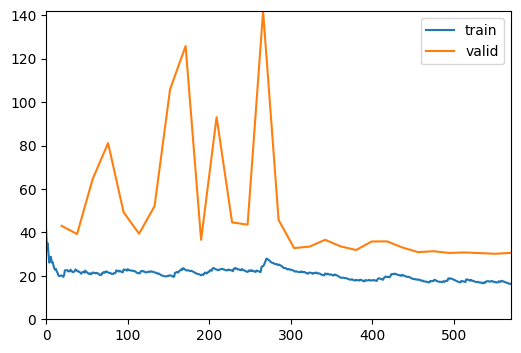

#params: 16831504


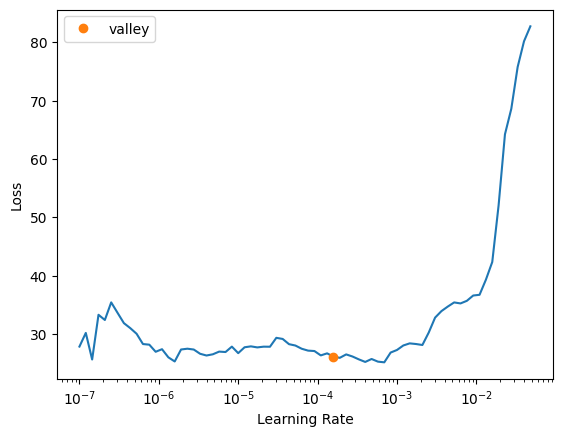

In [159]:
from swdf.metrics import LossMetrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = wMSELoss(thresholds, weights).to(device)
metrics = LossMetrics(loss, 'SOLFSMY').get_metrics()

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learner1 = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.learner1.arch), 
                     init=config.learner1.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learner1.lr_find().valley if config.lr_max is None else config.lr_max

learner1.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)
print(f"#params: {sum(p.numel() for p in learner1.model.parameters())}") 

epoch,train_loss,valid_loss,Loss_Low,Loss_Moderate,Loss_Elevated,Loss_High,time
0,1.002545,1.397426,0.167204,0.040666,0.220385,0.969172,00:00
1,1.025992,1.310138,0.171416,0.039143,0.213629,0.885950,00:00
2,0.994043,1.487890,0.185268,0.046756,0.277447,0.978419,00:00
3,1.016923,1.677426,0.200994,0.048915,0.277385,1.150132,00:00
4,1.072375,1.960765,0.232245,0.058448,0.345452,1.324620,00:00
5,1.048931,1.612127,0.186870,0.045797,0.271139,1.108320,00:00
6,1.063180,1.709438,0.202909,0.051842,0.309427,1.145261,00:00
7,1.027181,1.531320,0.190194,0.046425,0.267554,1.027147,00:00
8,1.037143,1.470024,0.169713,0.041858,0.249084,1.009368,00:00
9,0.984761,1.415174,0.169535,0.042821,0.234117,0.968701,00:00


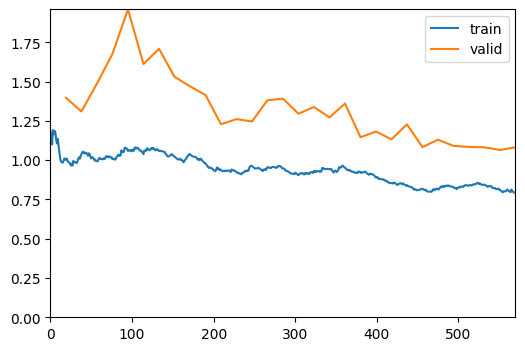

#params: 16831504


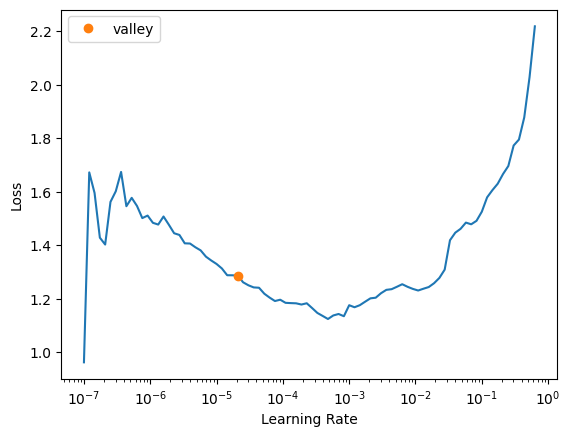

In [160]:
loss = wMAELoss(thresholds, weights).to(device)
metrics = LossMetrics(loss, 'SOLFSMY').get_metrics()

learner2 = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.learner2.arch), 
                     init=config.learner2.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learner2.lr_find().valley if config.lr_max is None else config.lr_max

learner2.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)
print(f"#params: {sum(p.numel() for p in learner2.model.parameters())}") 

In [161]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = (learner1.validate()[0] + learner2.validate()[0]) / 2
print(valid_loss)
%store valid_loss

15.836395919322968
Stored 'valid_loss' (float)


In [162]:
# Log the test loss to wandb
test_loss = (learner1.validate(ds_idx=2)[0] + learner2.validate(ds_idx=2)[0]) / 2
print(test_loss)

3.4417924731969833


In [163]:
# Save everything
learner1.dls.loaders += [learner1.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
learner2.dls.loaders += [learner2.dls.valid.new_dl(X[splits[2]], y[splits[2]])]

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learner1.remove_cb(wandb_callback)
    learner2.remove_cb(wandb_callback)

In [164]:
best_valid_loss = np.inf
%store -r best_valid_loss

save_all_or_best = (config.is_optuna_study and valid_loss < best_valid_loss) or not config.is_optuna_study

if save_all_or_best:
    best_valid_loss = valid_loss
    %store best_valid_loss  
    
    # Save locally and in wandb if online and enabled
    learner1.save_all(path='tmp', verbose=True, model_fname="model_learner1", learner_fname="learner_learner1") 
    learner2.save_all(path='tmp', verbose=True, model_fname="model_learner2", learner_fname="learner_learner2") 

    if run is not None and config.wandb.mode and config.wandb.log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='solfsmy')
    
    # Save the best model
    model = {}
    model['models'] = [learner1.model, learner2.model]
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = data_columns
    model['thresholds'] = yaml2dict("distributions/thresholds.yaml")

    torch.save(model, './models/best_model_ensemble_fsmy.pth')

Stored 'best_valid_loss' (float)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner1.pth'
learner_fname = 'learner_learner1.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner2.pth'
learner_fname = 'learner_learner2.pkl'
